In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import scipy as sp
import matplotlib.pyplot as plt
import tqdm

# Create fake single-cell atac-seq data
counts = pd.DataFrame(np.random.randint(0, 100, size=(50, 200)),
                      index=['Cell_'+i for i in map(str, range(50))],
                      columns=['chr1_'+i+'_'+i for i in map(str, range(200))])

atac = ad.AnnData(counts)


def add_region_infos(AnnData,
                     sep=('_', '_'),
                     inplace=True):
    """
    Get region informations from the var_names of AnnData object.
    e.g. chr1_12345_12346 -> 'chromosome' : chr1, 'start' : 12345, 'end' : 12346
    These info will be added to var of AnnData object.
        adata.var['chromosome'] : chromosome
        adata.var['start'] : start position
        adata.var['end'] : end position

    Parameters
    ----------
    AnnData : AnnData object
        AnnData object with var_names as region names.
    sep : tuple, optional
        Separator of region names. The default is ('_', '_').
    
    Returns
    -------
    AnnData : AnnData object
        AnnData object with region informations in var.
    """
    # Check if user wants to modify AnnData inplace or return a copy
    if inplace:
        pass
    else:
        AnnData = AnnData.copy()
    regions_list = AnnData.var_names

    # Replace sep[1] with sep[0] to make it easier to split
    regions_list = regions_list.str.replace(sep[1], sep[0])

    # Split region names
    regions_list = regions_list.str.split(sep[0]).tolist()

    # Check if all regions have the same number of elements
    if set([len(i) for i in regions_list]) != set([3]):
        raise ValueError("""Not all regions have the same number of elements.
                         Check if sep is correct, it should be ({}, {}),
                         with only one occurence each in region names.""".format(sep[0], sep[1]))

    # Extract region informations from var_names
    region_infos = pd.DataFrame(regions_list,
                                index=AnnData.var_names,
                                columns=['chromosome', 'start', 'end'])

    # Convert start and end to int
    region_infos['start'] = region_infos['start'].astype(int)
    region_infos['end'] = region_infos['end'].astype(int)

    # Add region informations to var
    AnnData.var['chromosome'] = region_infos['chromosome']
    AnnData.var['start'] = region_infos['start']
    AnnData.var['end'] = region_infos['end']

    sort_regions(AnnData)
    # Return AnnData if inplace is False
    if inplace:
        pass
    else:
        return AnnData


def sort_regions(AnnData):
    """
    Sort regions by chromosome and start position.
    """
    AnnData.var.sort_values(['chromosome', 'start'], inplace=True)
    return AnnData


def get_distance_regions(AnnData, chromosomes=None):
    """
    Get distance between regions.
    """
    # Check if chromosomes is None
    if chromosomes is None:
        # Get chromosome list
        chromosomes = AnnData.var['chromosome'].unique().tolist()
    else:
        if not np.array([i in AnnData.var['chromosome'].unique() for i in chromosomes]).all():
            raise ValueError("""Chromosomes should be in AnnData.var['chromosome'].
                                Check if chromosomes is correct.""")

    # A dictionary to store distance between regions for each chromosome
    distances = {}

    # Get distance between regions for each chromosome
    for chromosome in chromosomes:
        chr_mask = AnnData.var['chromosome']==chromosome
        # Store start and end positions in two arrays
        m, n = np.meshgrid(AnnData.var['start'].values[chr_mask],
                           AnnData.var['end'].values[chr_mask])

        # Get distance between start of region m and end of region n
        distance = np.abs(m-n)
        # Substract length of the region to get distance between
        # end of region m and start of region n
        # a.k.a. distance between closest bases of two regions
        distance = (distance.T-(AnnData.var['end'].values[chr_mask]
                                - AnnData.var['start'].values[chr_mask])).T

        # Remove diagonal (distance between a region and itself)
        distance -= np.diag(distance)

        # Keep upper triangle of the distance matrix
        # (we don't want to calculate the same connection twice)
        distance = np.triu(distance, k=1)

        # Test if distance is negative
        if np.any(distance < 0):
            raise ValueError("""Distance between regions should be positive.
                            You might have overlapping regions.""")

        # Store distance in a dictionary
        distances[chromosome] = distance

    # Return distance
    return distances


def potential_connections(AnnData, threshold, chromosomes=None):
    """
    Get potential connections between regions based on distance.
    """
    # Check if chromosomes is None
    if chromosomes is None:
        # Get chromosome list
        chromosomes = AnnData.var['chromosome'].unique().tolist()
    else:
        if not np.array([i in AnnData.var['chromosome'].unique() for i in chromosomes]).all():
            raise ValueError("""Chromosomes should be in AnnData.var['chromosome'].
                                Check if chromosomes is correct.""")
    # Get distance between regions
    distances = get_distance_regions(AnnData, chromosomes=chromosomes)

    potential_connections = {}
    # Get potential connections
    for chromosome in chromosomes:
        print("Getting potential connections for chromosome {}...".format(chromosome))
        # Get potential connections for each chromosome
        distance = distances[chromosome]
        potential_chr_co = np.where((distance <= threshold)
                                         & (distance > 0))

        # Store potential connections in a dictionary
        potential_connections[chromosome] = potential_chr_co

    # Return potential connections
    return potential_connections


def corrcoef_connections(AnnData, potential_connections, as_sparse=True):
    """
    Get correlation coefficient between regions.
    """
    # Transform potential_connections into a sparse matrix
    potential_connections = global_sparse(AnnData, potential_connections)

    # Get correlation coefficient between regions
    corr_coefs = [np.corrcoef(AnnData.X[:, potential_connections.row[i]],
                              AnnData.X[:, potential_connections.col[i]])[0, 1]
                  for i in tqdm.tqdm(range(len(potential_connections.row)))]

    # Convert to sparse matrix if as_sparse is True
    if as_sparse:
        corr_coefs = sp.sparse.coo_matrix((corr_coefs,
                                           (potential_connections.row,
                                            potential_connections.col)),
                                          shape=(AnnData.shape[1],
                                                 AnnData.shape[1]))
    else:
        corr_coefs = np.array(corr_coefs)
    
    # Return correlation coefficients
    return corr_coefs




    # A dictionary storing the informations to create a sparse matrix of potential connections
    corr_coefs = {}
    corr_coefs['values'] = np.array([])
    corr_coefs['idx'] = np.array([])
    corr_coefs['idy'] = np.array([])

    # Get correlation coefficient between regions for each chromosome
    for chromosome in potential_connections.keys():
        chr_mask = AnnData.var['chromosome']==chromosome
        print("Getting correlation coefficient for chromosome {}...".format(chromosome))

        corr_coefs_chr = [np.corrcoef(AnnData.X[:,chr_mask][:, potential_connections[chromosome][0][i]],
                                      AnnData.X[:,chr_mask][:, potential_connections[chromosome][1][i]])[0, 1]
                          for i in range(len(potential_connections[chromosome][0]))]

        # Store correlation coefficient in a dictionary
        corr_coefs[chromosome] = corr_coefs_chr
    return corr_coefs


def global_sparse(AnnData, chr_idx, values = 1):
    """
    Create a sparse matrix from a dictionary of np.where output on 'regions*regions' matrices.of different chromosomes.
    using global indices of an AnnData object.

    e.g.:
    AnnData.var_names = ['chr1_12345_12346', 'chr1_12347_12348', 'chr2_12345_12346', 'chr2_12347_12348']
    And we know values for  (chr1_12345_12346, chr1_12347_12348),
                            (chr1_12347_12348, chr1_12345_12346),
                            (chr2_12345_12346, chr2_12345_12346),
                            (chr2_12347_12348, chr2_12347_12348).
    
    We can create a sparse matrix with 'chr_dic' defined as:
    chr_dic = {'chr1' : np.array([[1, 0], [0, 1]]),
               'chr2' : np.array([[0, 0], [1, 1]])}

    sparse_mtx = global_sparse(AnnData, chr_dic)
    sparse_mtx
    'OUTPUT' :               chr_1_12345_12346  chr_1_12347_12348  chr_2_12345_12346  chr_2_12347_12348
    chr_1_12345_12346                 *                  1                  *                  *
    chr_1_12347_12348                 1                  *                  *                  *
    chr_2_12345_12346                 *                  *                  1                  *
    chr_2_12347_12348                 *                  *                  *                  1

    Parameters
    ----------
    AnnData : AnnData object
        AnnData object with var_names as region names.
    chr_dic : dictionary
        Dictionary of matrices (regions*regions) of different chromosomes.
    """

    data = {}
    data['values'] = np.array([])
    data['idx'] = np.array([])
    data['idy'] = np.array([])

    for chromosome in chr_idx.keys():
        chr_mask = AnnData.var['chromosome'] == chromosome
        # Get region names (needed to get global indices)
        indices_names = AnnData.var_names[chr_mask][chr_idx[chromosome][0]]
        columns_names = AnnData.var_names[chr_mask][chr_idx[chromosome][1]]
        map_indices = {AnnData.var_names[i]: i
                       for i in range(len(AnnData.var_names))}

        # Add global indices of potential connections
        data['idx'] = np.concatenate([data['idx'],
                                      indices_names.map(map_indices).values])
        data['idy'] = np.concatenate([data['idy'],
                                      columns_names.map(map_indices).values])
        # Add values of potential connections
        if type(values) == int:
            val = np.repeat(values, len(chr_idx[chromosome][0]))
        elif type(values) == dict:
            val = values[chromosome]
        else:
            raise ValueError("""values should be an int,
                             or a dict (of numpy arrays).""")
        data['values'] = np.concatenate([data['values'],
                                         val])
    # Create sparse matrix
    sparse_data = sp.sparse.coo_matrix((data['values'],
                                        (data['idx'],
                                         data['idy'])),
                                       shape=(AnnData.shape[1],
                                              AnnData.shape[1]))

    return sparse_data


In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scipy as sp

In [3]:
# Create fake single-cell atac-seq data
nb_cells = 300
nb_chr = 10
nb_regions_per_chr = 5000
between_reg = 1000
size_reg = 50

counts = []
for chr in range(nb_chr):
    counts.append(pd.DataFrame(np.random.randint(0,100, size=(nb_cells, nb_regions_per_chr)),
                        index=['Cell_'+i for i in map(str, range(nb_cells))],
                        columns=['chr'+str(chr)+'_'+str(i)+'_'+str(i+size_reg) for i in range(1, nb_regions_per_chr*between_reg+1, between_reg)]))
atac = ad.AnnData(pd.concat(counts))
atac,atac.var_names

/home/rtrimbou/miniconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(AnnData object with n_obs × n_vars = 3000 × 50000,
 Index(['chr0_1_51', 'chr0_1001_1051', 'chr0_2001_2051', 'chr0_3001_3051',
        'chr0_4001_4051', 'chr0_5001_5051', 'chr0_6001_6051', 'chr0_7001_7051',
        'chr0_8001_8051', 'chr0_9001_9051',
        ...
        'chr9_4990001_4990051', 'chr9_4991001_4991051', 'chr9_4992001_4992051',
        'chr9_4993001_4993051', 'chr9_4994001_4994051', 'chr9_4995001_4995051',
        'chr9_4996001_4996051', 'chr9_4997001_4997051', 'chr9_4998001_4998051',
        'chr9_4999001_4999051'],
       dtype='object', length=50000))

In [4]:
distance_threshold = 100000

In [5]:
add_region_infos(atac)

In [6]:
distance = get_distance_regions(atac)

In [7]:
distance

{'chr0': array([[      0,     900,    1900, ..., 4996900, 4997900, 4998900],
        [      0,       0,     900, ..., 4995900, 4996900, 4997900],
        [      0,       0,       0, ..., 4994900, 4995900, 4996900],
        ...,
        [      0,       0,       0, ...,       0,     900,    1900],
        [      0,       0,       0, ...,       0,       0,     900],
        [      0,       0,       0, ...,       0,       0,       0]]),
 'chr1': array([[      0,     900,    1900, ..., 4996900, 4997900, 4998900],
        [      0,       0,     900, ..., 4995900, 4996900, 4997900],
        [      0,       0,       0, ..., 4994900, 4995900, 4996900],
        ...,
        [      0,       0,       0, ...,       0,     900,    1900],
        [      0,       0,       0, ...,       0,       0,     900],
        [      0,       0,       0, ...,       0,       0,       0]]),
 'chr2': array([[      0,     900,    1900, ..., 4996900, 4997900, 4998900],
        [      0,       0,     900, ..., 4995900,

In [8]:
potential_connections_atac = potential_connections(atac, threshold=distance_threshold)

Getting potential connections for chromosome chr0...
Getting potential connections for chromosome chr1...
Getting potential connections for chromosome chr2...
Getting potential connections for chromosome chr3...
Getting potential connections for chromosome chr4...
Getting potential connections for chromosome chr5...
Getting potential connections for chromosome chr6...
Getting potential connections for chromosome chr7...
Getting potential connections for chromosome chr8...
Getting potential connections for chromosome chr9...


In [9]:
potential_connections_atac

{'chr0': (array([   0,    0,    0, ..., 4997, 4997, 4998]),
  array([   1,    2,    3, ..., 4998, 4999, 4999])),
 'chr1': (array([   0,    0,    0, ..., 4997, 4997, 4998]),
  array([   1,    2,    3, ..., 4998, 4999, 4999])),
 'chr2': (array([   0,    0,    0, ..., 4997, 4997, 4998]),
  array([   1,    2,    3, ..., 4998, 4999, 4999])),
 'chr3': (array([   0,    0,    0, ..., 4997, 4997, 4998]),
  array([   1,    2,    3, ..., 4998, 4999, 4999])),
 'chr4': (array([   0,    0,    0, ..., 4997, 4997, 4998]),
  array([   1,    2,    3, ..., 4998, 4999, 4999])),
 'chr5': (array([   0,    0,    0, ..., 4997, 4997, 4998]),
  array([   1,    2,    3, ..., 4998, 4999, 4999])),
 'chr6': (array([   0,    0,    0, ..., 4997, 4997, 4998]),
  array([   1,    2,    3, ..., 4998, 4999, 4999])),
 'chr7': (array([   0,    0,    0, ..., 4997, 4997, 4998]),
  array([   1,    2,    3, ..., 4998, 4999, 4999])),
 'chr8': (array([   0,    0,    0, ..., 4997, 4997, 4998]),
  array([   1,    2,    3, ..., 4998

In [ ]:
b = corrcoef_connections(atac, potential_connections_atac, as_sparse=True)

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4285337/4949500 [03:41<00:37, 17744.92it/s]

<Axes: >

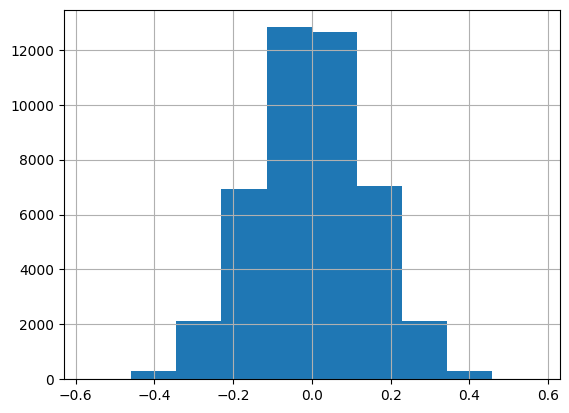

In [410]:
pd.Series(b.data).hist()

In [284]:
coefs = corrcoef_connections(atac, potential_connections_atac, as_sparse=False)
len(coefs)

Getting correlation coefficient for chromosome chr1...
Getting correlation coefficient for chromosome chr2...


2

In [285]:
coefs['chr1']

[-0.22986885981685154,
 0.20951591563150118,
 0.16851668407232723,
 0.021351935775032856,
 0.07497371879922587,
 0.0002373641619058134,
 0.2733431674081896,
 0.03205833974287685,
 -0.03814737688276851,
 -0.05585653149339897,
 0.1800133608521856,
 -0.07456177487523408,
 0.0469271511464623,
 0.1882120797951599,
 0.006897044180381482,
 -0.06183551190143172,
 0.19551572756628996,
 -0.1665253907543526,
 -0.033043129207228704,
 -0.24425763361715427,
 0.05013336602490633,
 -0.02328578743726905,
 0.15829843256363452,
 0.05095699155179819,
 0.05641092641826044,
 0.04599559414831566,
 0.07285740791477584,
 0.1790706027175697,
 0.10515858498866079,
 -0.03280931916121594,
 -0.004966853336619184,
 -0.07636545923188552,
 0.11972409012574672,
 -0.19822649039329196,
 0.061946304420748236,
 -0.03915890337181339,
 0.03463346385844941,
 0.13825007249235144,
 -0.06955801796020519,
 0.0026203550016029352,
 0.04567053636119318,
 -0.025038569275625082,
 0.009609859974391824,
 -0.01854457027286071,
 -0.144946

In [28]:
m, n = np.meshgrid(atac.var['start'], atac.var['end'])

# Get distance between start of region m and end of region n
distance = np.abs(m-n)
# Substract length of the region to get distance between
# end of region m and start of region n
# a.k.a. distance between closest bases of two regions


In [32]:
(atac.var['end']-atac.var['start'])

chr1_1_6            5
chr1_51_56          5
chr1_101_106        5
chr1_151_156        5
chr1_201_206        5
                   ..
chr2_19751_19756    5
chr2_19801_19806    5
chr2_19851_19856    5
chr2_19901_19906    5
chr2_19951_19956    5
Length: 800, dtype: int64

In [132]:
np.array([i in [1,2,3] for i in [1,4]]).all()

False

In [114]:
(distance[:,0]==0)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [112]:
distance

array([[    0,    40,    90, ..., 19840, 19890, 19940],
       [   50,     0,    40, ..., 19790, 19840, 19890],
       [  100,    50,     0, ..., 19740, 19790, 19840],
       ...,
       [19850, 19800, 19750, ...,     0,    40,    90],
       [19900, 19850, 19800, ...,    50,     0,    40],
       [19950, 19900, 19850, ...,   100,    50,     0]])

In [260]:
atac.var_names

Index(['chr1_1_6', 'chr1_51_56', 'chr1_101_106', 'chr1_151_156',
       'chr1_201_206', 'chr1_251_256', 'chr1_301_306', 'chr1_351_356',
       'chr1_401_406', 'chr1_451_456',
       ...
       'chr2_19501_19506', 'chr2_19551_19556', 'chr2_19601_19606',
       'chr2_19651_19656', 'chr2_19701_19706', 'chr2_19751_19756',
       'chr2_19801_19806', 'chr2_19851_19856', 'chr2_19901_19906',
       'chr2_19951_19956'],
      dtype='object', length=800)

In [265]:
np.where(atac.var_names.isin(['chr1_1_6', 'chr1_51_56']))[0]

array([0, 1])

In [273]:
np.concatenate([np.array([]), np.array([1,2])])

array([1., 2.])

In [286]:
potential_connections_atac['chr1']

(array([  0,   0,   0, ..., 397, 397, 398]),
 array([  1,   2,   3, ..., 398, 399, 399]))

In [359]:
global_sparse(atac, potential_connections_atac)

22170
22170
44340 44340 44340


<800x800 sparse matrix of type '<class 'numpy.float64'>'
	with 44340 stored elements in COOrdinate format>

In [301]:
potential_connections_atac['chr1']

(array([  0,   0,   0, ..., 397, 397, 398]),
 array([  1,   2,   3, ..., 398, 399, 399]))

In [340]:
chr_mask = atac.var['chromosome'] == 'chr1'
indices_names = atac.var_names[chr_mask][potential_connections_atac['chr1'][0]]

In [347]:
atac.var_names.get_loc('chr1_1_6')

0

In [357]:
indices_names.map(pd.Series([i for i in range(len(atac.var_names))], index=atac.var_names).to_dict())

Index([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       ...
       395, 395, 395, 395, 396, 396, 396, 397, 397, 398],
      dtype='int64', length=22170)

In [335]:
potential_connections_atac['chr1'][0]

array([  0,   0,   0, ..., 397, 397, 398])

In [354]:
pd.Series(atac.var_names).to_dict()

{0: 'chr1_1_6',
 1: 'chr1_51_56',
 2: 'chr1_101_106',
 3: 'chr1_151_156',
 4: 'chr1_201_206',
 5: 'chr1_251_256',
 6: 'chr1_301_306',
 7: 'chr1_351_356',
 8: 'chr1_401_406',
 9: 'chr1_451_456',
 10: 'chr1_501_506',
 11: 'chr1_551_556',
 12: 'chr1_601_606',
 13: 'chr1_651_656',
 14: 'chr1_701_706',
 15: 'chr1_751_756',
 16: 'chr1_801_806',
 17: 'chr1_851_856',
 18: 'chr1_901_906',
 19: 'chr1_951_956',
 20: 'chr1_1001_1006',
 21: 'chr1_1051_1056',
 22: 'chr1_1101_1106',
 23: 'chr1_1151_1156',
 24: 'chr1_1201_1206',
 25: 'chr1_1251_1256',
 26: 'chr1_1301_1306',
 27: 'chr1_1351_1356',
 28: 'chr1_1401_1406',
 29: 'chr1_1451_1456',
 30: 'chr1_1501_1506',
 31: 'chr1_1551_1556',
 32: 'chr1_1601_1606',
 33: 'chr1_1651_1656',
 34: 'chr1_1701_1706',
 35: 'chr1_1751_1756',
 36: 'chr1_1801_1806',
 37: 'chr1_1851_1856',
 38: 'chr1_1901_1906',
 39: 'chr1_1951_1956',
 40: 'chr1_2001_2006',
 41: 'chr1_2051_2056',
 42: 'chr1_2101_2106',
 43: 'chr1_2151_2156',
 44: 'chr1_2201_2206',
 45: 'chr1_2251_2256'